In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
tmp = pd.read_csv('Beehive Metrics Dataset/new_temp_2017.csv')
tmp.head()

,timestamp,min,max,mean
0,1/1/2017 5:00,-1.911244,4.505489,1.699496
1,1/1/2017 6:00,-3.370600,4.495117,1.092577
2,1/1/2017 7:00,-3.582800,4.276133,0.964174
3,1/1/2017 8:00,-3.881800,3.711483,0.824071
4,1/1/2017 9:00,-4.742200,3.108950,0.266976


In [3]:
hum = pd.read_csv('Beehive Metrics Dataset/humidity_2017.csv')
hum.head()

,timestamp,humidity
0,2017-01-01 05:00:00,92.406667
1,2017-01-01 06:00:00,92.270000
2,2017-01-01 07:00:00,92.575000
3,2017-01-01 08:00:00,92.840000
4,2017-01-01 09:00:00,93.640000


In [4]:
flow = pd.read_csv('Beehive Metrics Dataset/new_flow_2017.csv')
flow.head()

,timestamp,out,in
0,1/1/2017 5:15,0,0
1,1/1/2017 5:16,0,0
2,1/1/2017 5:17,0,0
3,1/1/2017 5:18,0,0
4,1/1/2017 5:19,0,0


In [5]:
weight = pd.read_csv('Beehive Metrics Dataset/weight_2017.csv')
weight.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [6]:
#Change the timestamp fields to the datetime data type
tmp['timestamp'] = pd.to_datetime(tmp['timestamp'])
hum['timestamp'] = pd.to_datetime(hum['timestamp'])
flow['timestamp'] = pd.to_datetime(flow['timestamp'])
weight['timestamp'] = pd.to_datetime(weight['timestamp'])

In [7]:
#Check the datatypes
tmp.info()
hum.info()
flow.info()
weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104821 entries, 0 to 104820
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  104821 non-null  datetime64[ns]
 1   min        104821 non-null  float64       
 2   max        104821 non-null  float64       
 3   mean       104821 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8737 entries, 0 to 8736
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8737 non-null   datetime64[ns]
 1   humidity   8737 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 136.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524050 entries, 0 to 524049
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------

In [8]:
#Count blanks or whitespaces
tmp = tmp.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
tmp.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [9]:
hum = hum.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
hum.isnull().sum()

timestamp    0
humidity     0
dtype: int64

In [10]:
flow = flow.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
flow.isnull().sum()

timestamp    0
out          0
in           0
dtype: int64

In [11]:
weight = weight.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
weight.isnull().sum()

timestamp    0
weight       0
dtype: int64

In [12]:
#Remove what we need to from hum
hum = hum.drop([3006, 3007])

In [13]:
tmp.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [14]:
#Merge humidity and temp together
tmpdf = hum.merge(tmp, how='left', on='timestamp')
tmpdf.head(20)

,timestamp,humidity,min,max,mean
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033


In [15]:
#Merge flow in
tmpdf2 = tmpdf.merge(flow, how='left', on='timestamp')
tmpdf2.head(20)

,timestamp,humidity,min,max,mean,out,in
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496,NaN,NaN
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577,0.0,0.0
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174,0.0,0.0
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071,0.0,0.0
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976,0.0,0.0
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223,0.0,0.0
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697,0.0,0.0
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183,0.0,0.0
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385,0.0,0.0
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033,0.0,0.0


In [16]:
#Merge weight in
df = tmpdf2.merge(weight, how='left', on='timestamp')
df.head(20)

,timestamp,humidity,min,max,mean,out,in,weight
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496,NaN,NaN,NaN
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577,0.0,0.0,52.6972
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174,0.0,0.0,52.6972
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071,0.0,0.0,52.6652
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976,0.0,0.0,52.6652
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223,0.0,0.0,52.4731
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697,0.0,0.0,52.4091
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183,0.0,0.0,52.5051
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385,0.0,0.0,52.6332
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033,0.0,0.0,52.6972


In [17]:
#Looks like we got some nulls in there somewhere along the line
df.isnull().sum()

timestamp    0
humidity     0
min          0
max          0
mean         0
out          1
in           1
weight       1
dtype: int64

In [18]:
df = df.dropna()

In [19]:
#Calc St. Deviation
df.std()

timestamp    105 days 02:21:13.753268182
humidity                       15.466037
min                             8.457021
max                             9.922066
mean                            9.823586
out                            29.219061
in                             25.858749
weight                          6.151561
dtype: object

In [20]:
#Values within the 50% quantile
df.quantile

<bound method DataFrame.quantile of                timestamp   humidity      min        max       mean  out   in  \
1    2017-01-01 06:00:00  92.270000  -3.3706   4.495117   1.092577  0.0  0.0   
2    2017-01-01 07:00:00  92.575000  -3.5828   4.276133   0.964174  0.0  0.0   
3    2017-01-01 08:00:00  92.840000  -3.8818   3.711483   0.824071  0.0  0.0   
4    2017-01-01 09:00:00  93.640000  -4.7422   3.108950   0.266976  0.0  0.0   
5    2017-01-01 10:00:00  93.768333  -4.7170   3.360517   0.107223  0.0  0.0   
...                  ...        ...      ...        ...        ...  ...  ...   
8732 2017-12-31 01:00:00  90.255000  10.3460  19.169333  14.246423  0.0  0.0   
8733 2017-12-31 02:00:00  91.685000   9.9300  19.855500  14.212385  0.0  0.0   
8734 2017-12-31 03:00:00  92.323333   9.8000  19.935333  14.322692  0.0  0.0   
8735 2017-12-31 04:00:00  92.675000  10.0100  19.812000  14.597641  0.0  0.0   
8736 2017-12-31 05:00:00  91.900000  10.9820  19.657333  14.765385 -1.0  0.0   

   

In [21]:
#We can finally do covariance too!
df.cov()

,humidity,min,max,mean,out,in,weight
humidity,239.198294,-103.312905,-86.444624,-106.406757,244.867993,-219.343343,-74.298171
min,-103.312905,71.521203,65.985666,75.454115,-140.381040,127.854317,32.652295
max,-86.444624,65.985666,98.447390,90.899163,-118.728449,105.900004,19.864871
mean,-106.406757,75.454115,90.899163,96.502841,-149.657729,134.352779,30.159727
out,244.867993,-140.381040,-118.728449,-149.657729,853.753512,-697.129311,-65.939845
in,-219.343343,127.854317,105.900004,134.352779,-697.129311,668.674876,57.980842
weight,-74.298171,32.652295,19.864871,30.159727,-65.939845,57.980842,37.841701


In [22]:
#And correlation
df.corr()

,humidity,min,max,mean,out,in,weight
humidity,1.000000,-0.789875,-0.563322,-0.700358,0.541860,-0.548451,-0.780933
min,-0.789875,1.000000,0.786376,0.908229,-0.568100,0.584643,0.627641
max,-0.563322,0.786376,1.000000,0.932584,-0.409531,0.412749,0.325461
mean,-0.700358,0.908229,0.932584,1.000000,-0.521390,0.528895,0.499082
out,0.541860,-0.568100,-0.409531,-0.521390,1.000000,-0.922656,-0.366857
in,-0.548451,0.584643,0.412749,0.528895,-0.922656,1.000000,0.364495
weight,-0.780933,0.627641,0.325461,0.499082,-0.366857,0.364495,1.000000


<AxesSubplot:>

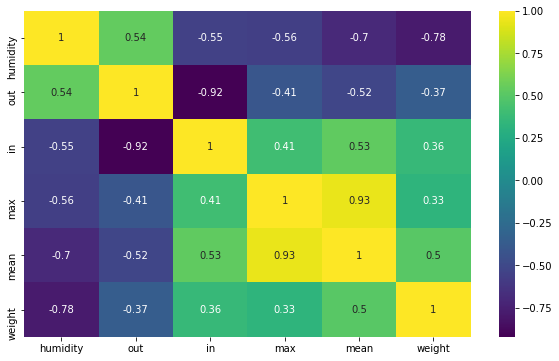

In [23]:
#Visualize correlation
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Heatmap')
    labels=['humidity', 'min', 'max', 'mean', 'out', 'in', 'weight']
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    fig.colorbar(cax, ticks=[-1,-.5,0,.5,1])
    plt.show()

#Quality correlation matrix
k = 6 #number of variables for heatmap
cols = df.corr().nlargest(k, 'humidity')['humidity'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [24]:
df2 = df[["humidity","min","max","mean","out","in", "weight"]]

In [25]:
ss = StandardScaler()
ss.fit_transform(df2)

array([[ 1.12128469, -1.90834677, -2.29645765, ...,  0.50666991,
        -0.51325186, -0.52890805],
       [ 1.14100645, -1.93343979, -2.31852925, ...,  0.50666991,
        -0.51325186, -0.52890805],
       [ 1.15814175, -1.96879705, -2.37544102, ...,  0.50666991,
        -0.51325186, -0.53411028],
       ...,
       [ 1.12473331, -0.35090071, -0.74021918, ...,  0.50666991,
        -0.51325186, -0.37280865],
       [ 1.1474726 , -0.32606785, -0.7526501 , ...,  0.50666991,
        -0.51325186, -0.37280865],
       [ 1.09735994, -0.21112719, -0.76823914, ...,  0.47244371,
        -0.51325186, -0.35199973]])

In [26]:
df2.head(20)

,humidity,min,max,mean,out,in,weight
1,92.270000,-3.3706,4.495117,1.092577,0.0,0.0,52.6972
2,92.575000,-3.5828,4.276133,0.964174,0.0,0.0,52.6972
3,92.840000,-3.8818,3.711483,0.824071,0.0,0.0,52.6652
4,93.640000,-4.7422,3.108950,0.266976,0.0,0.0,52.6652
5,93.768333,-4.7170,3.360517,0.107223,0.0,0.0,52.4731
6,92.950000,-3.4038,5.602583,0.618697,0.0,0.0,52.4091
7,92.080000,-2.7678,4.588617,0.892183,0.0,0.0,52.5051
8,91.356667,-2.1272,4.864967,1.330385,0.0,0.0,52.6332
9,91.071667,-1.6358,5.755283,1.723033,0.0,0.0,52.6972
10,90.996667,-1.3362,6.023483,1.861309,0.0,0.0,52.7132


In [27]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

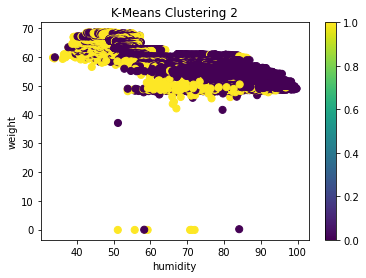

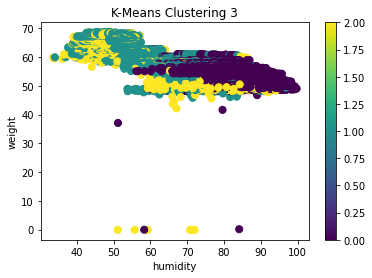

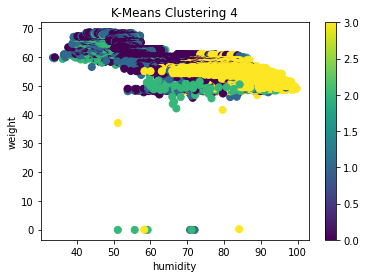

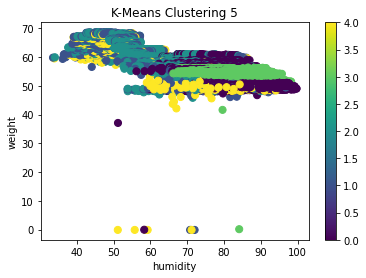

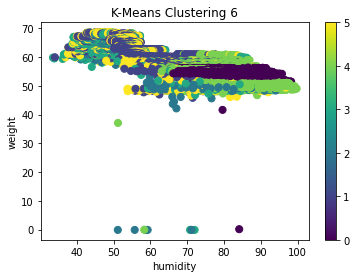

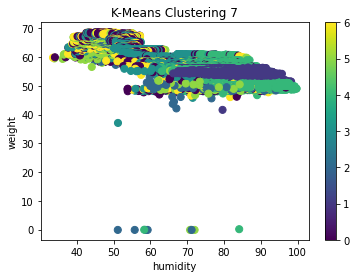

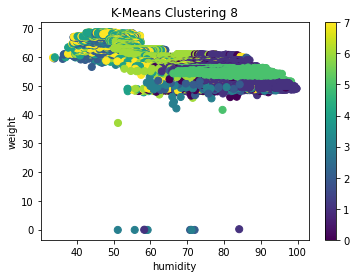

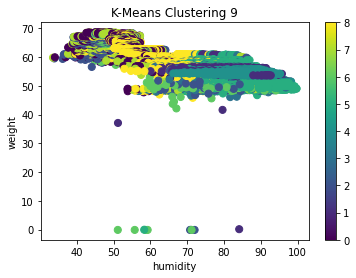

In [31]:
for i in range(2,10):
    clust_labels, cent = doKmeans(df2, i)
    kmeans = pd.DataFrame(clust_labels)
    #Plot the clusters obtained using k means
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df2['humidity'],df2['weight'],
                         c=kmeans[0],s=50)
    ax.set_title('K-Means Clustering ' +  str(i))
    ax.set_xlabel('humidity')
    ax.set_ylabel('weight')
    plt.colorbar(scatter)

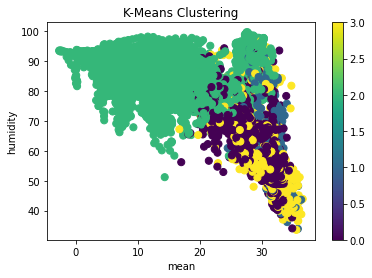

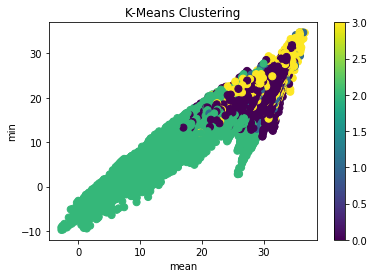

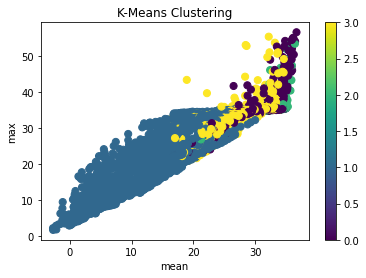

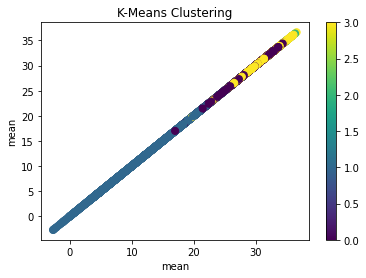

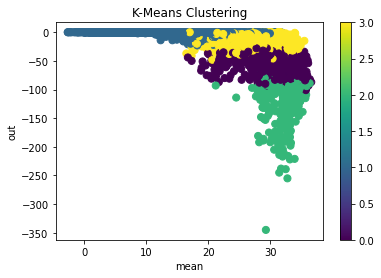

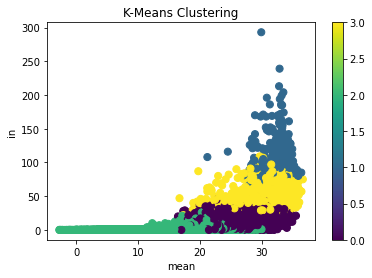

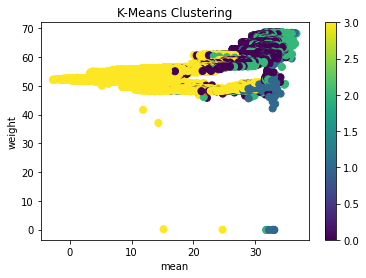

In [32]:
for col in df2:
    clust_labels, cent = doKmeans(df2, 4)
    kmeans = pd.DataFrame(clust_labels)
    #Plot the clusters obtained using k means
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df2['mean'],df2[col],
                         c=kmeans[0],s=50)
    ax.set_title('K-Means Clustering')
    ax.set_xlabel('mean')
    ax.set_ylabel(col)
    plt.colorbar(scatter)